In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
class TicTacToe:
    # Define attributes of tictactoe.
    def __init__(self, size=4):
        self.size = size
        self.board = np.zeros((self.size, self.size), dtype=int)
        self.done = False
        self.winner = None
    
    # Reset game.
    def reset(self):
        self.board = np.zeros((self.size, self.size), dtype=int)
        self.done = False
        self.winner = None
        return self.board
    
    # Check if moves are legal.
    def available_actions(self):
        return [(i, j) for i in range(self.size) for j in range(self.size) if self.board[i][j] == 0]
    
    
    def step(self, action, player):
        i, j = action
        self.board[i][j] = player
        if self.check_win(player):
            self.done = True
            self.winner = player
            return self.board, 1 if player == 1 else -1, self.done
        elif len(self.available_actions()) == 0:
            self.done = True
            self.winner = 0  # Draw
            return self.board, 0, self.done
        return self.board, 0, self.done
    
    def check_win(self, player):
        size = self.size
        # Check rows, columns.
        for i in range(size):
            if np.all(self.board[i, :] == player) or np.all(self.board[:, i] == player):
                return True
        # Check diag.
        if np.all(np.diag(self.board) == player) or np.all(np.diag(np.fliplr(self.board)) == player):
            return True
        return False


In [79]:
class SARSAAgent:
    def __init__(self, size=4, alpha=0.01, gamma=0.9, epsilon=0.25):
        self.size = size 
        self.alpha = alpha
        self.gamma = gamma # Discount.
        self.epsilon = epsilon # Control variable.
        self.Q = {}  # Q-table for state-action pairs
    
    def get_Q(self, state, action):
        state_tuple = tuple(map(tuple, state))  # Convert state to a hashable type
        return self.Q.get((state_tuple, action), 0.0) # 0.001 is default value if not exist.
    
    def update_Q(self, state, action, reward, next_state, next_action):
        # Turn lists inside state into tupple,
        # and then the whole state into tuple.
        state_tuple = tuple(map(tuple, state))
        next_state_tuple = tuple(map(tuple, next_state))
        old_Q = self.Q.get((state_tuple, action), 0.0)
        next_Q = self.Q.get((next_state_tuple, next_action), 0.0)
        # Update Q-value.
        new_Q = old_Q + self.alpha * (reward + self.gamma * next_Q - old_Q)
        self.Q[(state_tuple, action)] = new_Q
    
    def choose_action(self, state, available_actions):
        # Random explore/exploit.
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(available_actions)
        else:
            q_values = [self.get_Q(state, action) for action in available_actions]
            max_q = max(q_values)
            best_actions = [action for action, q in zip(available_actions, q_values) if q == max_q]
            return random.choice(best_actions)

In [89]:
class RandomOpponent:
    def choose_action(self, available_actions):
        return random.choice(available_actions)

# Then you can modify the training loop to include the opponent:
def train_sarsa(episodes, board_size):
    env = TicTacToe(size=board_size)
    agent = SARSAAgent(size=board_size)
    opponent = RandomOpponent()
    win_rates = []

    for episode in range(episodes):
        state = env.reset()
        available_actions = env.available_actions()
        action = agent.choose_action(state, available_actions)
        
        while not env.done:
            next_state, reward, done = env.step(action, player=1)
            if done:
                agent.update_Q(state, action, reward, next_state, None)
                break
            
            # Opponent's turn (player 2)
            opponent_action = opponent.choose_action(env.available_actions())
            next_state, reward, done = env.step(opponent_action, player=2)

            # Update the agent's Q-table based on the opponent's move
            if done:
                agent.update_Q(state, action, reward, next_state, None)
                break
            
            next_action = agent.choose_action(next_state, env.available_actions())
            agent.update_Q(state, action, reward, next_state, next_action)

            state, action = next_state, next_action
    

        if env.winner == 1:
            win_rates.append(1)
        elif env.winner == 0:
            win_rates.append(1)  # Draw
        else:
            win_rates.append(0)

    return win_rates



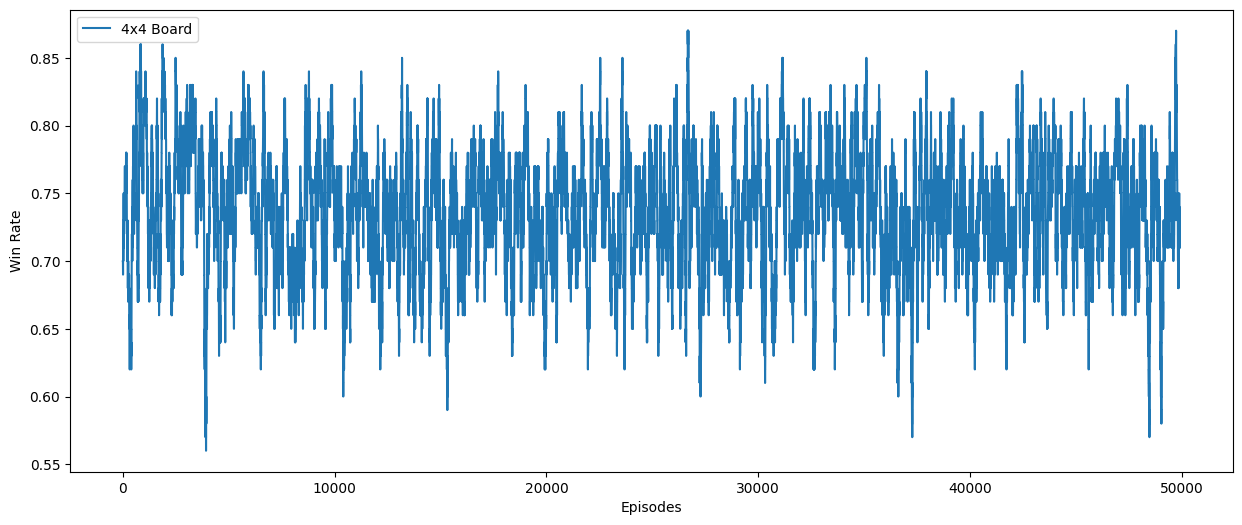

In [95]:
win_rates_4x4 = train_sarsa(episodes=50000, board_size=4)
plt.figure(figsize=(15, 6))
plt.plot(np.convolve(win_rates_4x4, np.ones(100)/100, mode='valid'), label='4x4 Board')
plt.xlabel('Episodes')
plt.ylabel('Win Rate')
plt.legend()
plt.show()

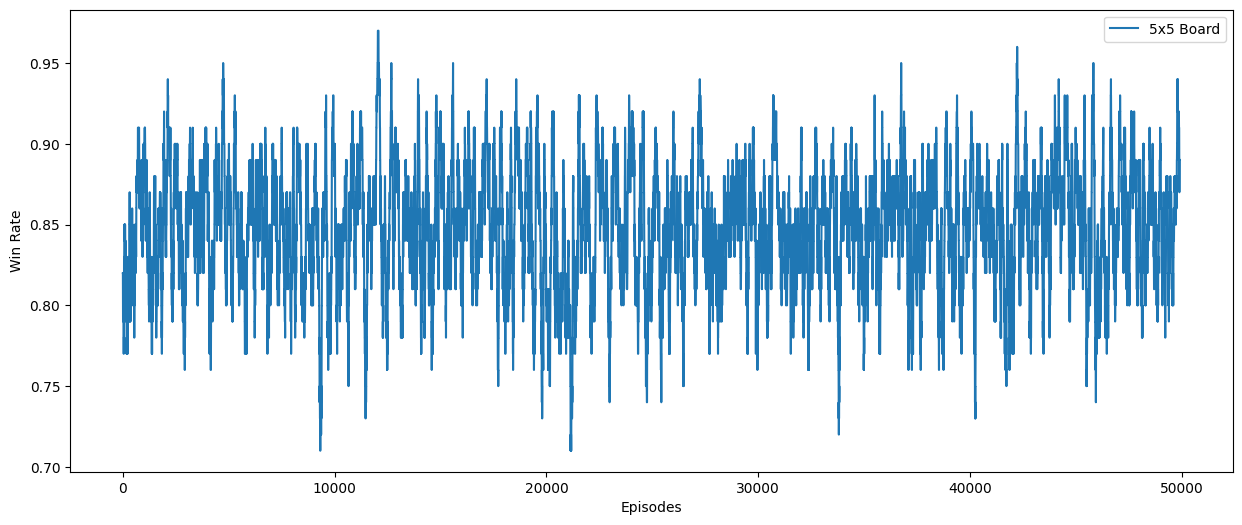

In [96]:
win_rates_5x5 = train_sarsa(episodes=50000, board_size=5)
plt.figure(figsize=(15, 6))
plt.plot(np.convolve(win_rates_5x5, np.ones(100)/100, mode='valid'), label='5x5 Board')
plt.xlabel('Episodes')
plt.ylabel('Win Rate')
plt.legend()
plt.show()